In [1]:
from transformers import set_seed
import torch

# random_seed = 42
random_seed = 80

set_seed(random_seed)

In [2]:
from transformers import CharacterBertModel
import torch.nn as nn

class CharacterBERTForMultipleChoice(nn.Module):
    def __init__(self):
          super(CharacterBERTForMultipleChoice, self).__init__()
          self.bert = CharacterBertModel.from_pretrained("E:\Documents\Character Bert\Hate Speech\character-bert-hindi")
          ### New layers:
          self.linear1 = nn.Linear(768, 1) ## 1 is the number of classes in this example

    def forward(self, input_ids,attention_mask,token_type_ids,position_ids,head_mask,\
                inputs_embeds,output_attentions,output_hidden_states,return_dict):
        outputs = self.bert(
            input_ids,
            attention_mask,
            token_type_ids,
            position_ids,
            head_mask,
            inputs_embeds,
            output_attentions,
            output_hidden_states,
            return_dict)
        
        pooled_output = outputs[1]
        logits = self.linear1(pooled_output)

        return logits

In [3]:
from datasets import load_dataset

train_dataset = load_dataset("json", data_files="..\datasets\copa-translated\\hi\\train.jsonl", \
                             split="train")

Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-4aa02a47edd70562/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [4]:
val_dataset = load_dataset("json", data_files="..\datasets\copa-translated\\hi\\val.jsonl", \
                            split="train")

Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-bfbd5b7cdea343df/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [5]:
test_dataset = load_dataset("json", data_files="..\datasets\copa-translated\\hi\\test.jsonl", \
                             split="train")

Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-0e1a32d75e6ec46c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [6]:
from datasets import Dataset, DatasetDict

datasets = DatasetDict()
datasets['train'] = train_dataset
datasets['validation'] = val_dataset
datasets['test'] = test_dataset

In [7]:
# from datasets import load_dataset

# datasets = load_dataset("indic_glue","copa.hi")

In [8]:
# datasets

In [9]:
datasets["train"][:50]

{'premise': ['मेरे शरीर ने घास पर छाया डाली।',
  'महिला ने अपने दोस्त के कठिन व्यवहार को सहन किया।',
  'महिलाएं कॉफी के लिए मिलीं।',
  'धावक ने शॉर्ट्स पहनी थी।',
  'पार्टी के मेहमान सोफे के पीछे छिप गए।',
  'राजनेता चुनाव हार गया।',
  'शर्ट से दाग निकल आया।',
  'आदमी को अपनी किराने का सामान पर छूट मिल गई।',
  'चिकित्सक ने मरीज को गलत बताया।',
  'ग्राहक ने स्टोर मैनेजर के पास शिकायत दर्ज कराई।',
  'महिला ने अपने नल की मरम्मत की।',
  'बुजुर्ग महिला को दौरा पड़ा।',
  'अपराधी ने पैरोल का उल्लंघन किया।',
  'मैंने अपने सोते हुए दोस्त पर पानी डाला।',
  'बाहर अंधेरा हो गया।',
  'मैंने फोन रख दिया।',
  'शॉवर में महिला की अंगूठी फिसल गई।',
  'लड़की को एक ट्रॉफी मिली।',
  'महिला की तारीख एक सज्जन की तरह दिखना चाहती थी।',
  'खेत को सिंचाई की जरूरत थी।',
  'मेजबान ने पार्टी को रद्द कर दिया।',
  'महिला ने पुरुष को अपना फोन नंबर दिया।',
  'स्काईडाइवर सुरक्षित रूप से जमीन पर चला गया।',
  'बच्चा क्रैंक हो गया।',
  'बच्चा रोग प्रतिरोधक हो गया।',
  'अंगूर का रस किण्वित।',
  'दोस्तों की बहस अंतर्मन पर खि

In [10]:
datasets["test"][:2]

{'premise': ['आइटम को बबल रैप में पैक किया गया था।',
  'मैंने अपनी जेबें खाली कर दीं।'],
 'choice1': ['यह नाजुक था।', 'मैंने एक टिकट स्टब को पुनः प्राप्त किया।'],
 'choice2': ['छोटा था।', 'मुझे एक हथियार मिला।'],
 'question': ['cause', 'effect'],
 'idx': [0, 1],
 'label': [0, 0]}

In [11]:
datasets.set_format("pandas")

In [12]:
# get label counts for both classes
label_counts = datasets["train"]["label"].value_counts()
num_labels = (len(label_counts.keys()))

In [13]:
label_counts

label
1    186
0    176
Name: count, dtype: int64

In [14]:
datasets.reset_format()

In [15]:
from transformers import BertForSequenceClassification, BertConfig, CharacterBertModel, CharacterBertTokenizer

tokenizer = CharacterBertTokenizer(strip_accents=None, do_lower_case=None)

In [16]:
choice_names = ['choice1', 'choice2']

In [17]:
def preprocess_function(examples):
    premise = [[context] * 2 for context in examples["premise"]]
    cause = [[f"{examples[choice][i]}" for choice in choice_names] for i,_ in enumerate(premise)]

    premise = sum(premise, [])
    cause = sum(cause, [])
    
#     print(premise)
#     print(cause)
    

    tokenized_examples = tokenizer(premise, cause, truncation=True, max_length=128, padding='max_length')
#     print(len(tokenized_examples))
    return {k: [v[i : i + 2] for i in range(0, len(v), 2)] for k, v in tokenized_examples.items()}
    return tokenized_examples

In [18]:
temp = preprocess_function(datasets["train"][:1])
len(temp)

3

In [19]:
tokenized_datasets = datasets.map(preprocess_function, batched=True)

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-4aa02a47edd70562\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-4f37415a4b80bb35.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-bfbd5b7cdea343df\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-5ee2de098a395602.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-0e1a32d75e6ec46c\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-e9799b7b5bdc26ac.arrow


In [20]:
from transformers import BertConfig, CharacterBertTokenizer, BertModel,\
                        TrainingArguments, Trainer, CharacterBertConfig, CharacterBertModel

model = CharacterBERTForMultipleChoice()

Some weights of the model checkpoint at E:\Documents\Character Bert\Hate Speech\character-bert-hindi were not used when initializing CharacterBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing CharacterBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CharacterBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'choice1', 'choice2', 'question', 'idx', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 362
    })
    validation: Dataset({
        features: ['premise', 'choice1', 'choice2', 'question', 'idx', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 88
    })
    test: Dataset({
        features: ['premise', 'choice1', 'choice2', 'question', 'idx', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 449
    })
})

In [22]:
# tokenized_datasets = tokenized_datasets.remove_columns(['premise', 'choice1', 'choice2', 'question', 'idx'])
tokenized_datasets = tokenized_datasets.remove_columns(['premise', 'choice1', 'choice2', 'question'])
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

{'train': ['idx', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
 'validation': ['idx',
  'label',
  'input_ids',
  'token_type_ids',
  'attention_mask'],
 'test': ['idx', 'label', 'input_ids', 'token_type_ids', 'attention_mask']}

In [23]:
# tokenized_datasets["train"][0]['input_ids'].size()

In [24]:
# tokenized_datasets["train"][0]['attention_mask'].size()

In [25]:
# tokenized_datasets["train"][0]['token_type_ids'].size()

In [26]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
from transformers import AdamW

# optimizer = AdamW(model.parameters(), lr=2e-5)
optimizer = AdamW(model.parameters(), lr=5e-5)

In [28]:
from transformers import get_scheduler

# num_epochs = 3
num_epochs = 2
num_training_steps = num_epochs * len(tokenized_datasets["train"])
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    #num_warmup_steps=0.05 * num_training_steps,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

724


In [29]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [30]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss

# classifier = nn.Linear(768, 1).to(device)
loss_fct = CrossEntropyLoss()

In [31]:
for item in tokenized_datasets["train"]:
    item = {k: v.to(device) for k, v in item.items()}
    position_ids=None
    head_mask=None
    inputs_embeds=None
    output_attentions=None
    output_hidden_states=None
    return_dict=None
    logits = model(
            input_ids=item["input_ids"],
            attention_mask=item["attention_mask"],
            token_type_ids=item["token_type_ids"],
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
    reshaped_logits = logits.view(-1, 2)
    print(reshaped_logits)
    print(item["label"].unsqueeze(0))
    loss = loss_fct(reshaped_logits, item["label"].unsqueeze(0))
    print(loss)
    break

tensor([[-0.1357, -0.1152]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0], device='cuda:0')
tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward0>)


In [32]:
import evaluate

metric = evaluate.load("accuracy")

In [33]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
accumulation_steps = 32

for epoch in range(num_epochs):
    model.train()
    training_losses = []
    for i, item in enumerate(tokenized_datasets["train"]):
        item = {k: v.to(device) for k, v in item.items()}
        logits = model(
                input_ids=item["input_ids"],
                attention_mask=item["attention_mask"],
                token_type_ids=item["token_type_ids"],
                position_ids=None,
                head_mask=None,
                inputs_embeds=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None
            )
        reshaped_logits = logits.view(-1, 2)
        loss = loss_fct(reshaped_logits, item["label"].unsqueeze(0))
        loss.backward()
        
        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step()                            # Now we can do an optimizer step
            optimizer.zero_grad()                       # Reset gradients tensors
    
        lr_scheduler.step()
        progress_bar.update(1)
        training_losses.append(loss.repeat(1))
    
    training_losses = torch.cat(training_losses)
    training_losses = training_losses[: len(tokenized_datasets["train"])]
    
    print(f">>> Epoch {epoch}: Training Loss: {torch.mean(training_losses)}")
    
    progress_bar2 = tqdm(range(len(tokenized_datasets["validation"])))

    model.eval()

    training_losses = []
    for item in tokenized_datasets["validation"]:
        item = {k: v.to(device) for k, v in item.items()}
        logits = model(
                input_ids=item["input_ids"],
                attention_mask=item["attention_mask"],
                token_type_ids=item["token_type_ids"],
                position_ids=None,
                head_mask=None,
                inputs_embeds=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None
            )
        reshaped_logits = logits.view(-1, 2)
        pred = torch.argmax(reshaped_logits)
        metric.add_batch(predictions=pred.unsqueeze(0), references=item["label"].unsqueeze(0))
        progress_bar2.update(1)

    acc = metric.compute()
    print("accuracy", acc)

  0%|          | 0/724 [00:00<?, ?it/s]

C:\Users\arifa\anaconda3\envs\character_bert\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


>>> Epoch 0: Training Loss: 0.700300395488739


  0%|          | 0/88 [00:00<?, ?it/s]

accuracy {'accuracy': 0.6136363636363636}
>>> Epoch 1: Training Loss: 0.6615414023399353


  0%|          | 0/88 [00:00<?, ?it/s]

accuracy {'accuracy': 0.625}


In [51]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(len(tokenized_datasets["test"])))

model.eval()

predictions = []
training_losses = []
for item in tokenized_datasets["test"]:
    item = {k: v.to(device) for k, v in item.items()}
    logits = model(
            input_ids=item["input_ids"],
            attention_mask=item["attention_mask"],
            token_type_ids=item["token_type_ids"],
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None
        )
    reshaped_logits = logits.view(-1, 2)
    pred = torch.argmax(reshaped_logits)
    predictions.append(pred.tolist())
    metric.add_batch(predictions=pred.unsqueeze(0), references=item["label"].unsqueeze(0))
    progress_bar.update(1)
        
acc = metric.compute()

  0%|          | 0/449 [00:00<?, ?it/s]

In [52]:
acc

{'accuracy': 0.5612472160356348}

In [53]:
y_true = tokenized_datasets['test']['label']

In [55]:
y_preds = predictions

In [56]:
from sklearn.metrics import classification_report
target_names = ['choice1', 'choice2']

Text(0.5, 1.0, 'Confusion matrix for COPA')

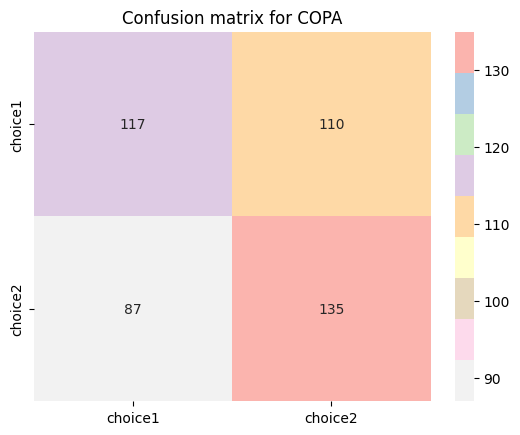

In [57]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

#plot heatmap of confusion matrix
mat = confusion_matrix(y_true, y_preds)
heatmap(mat, cmap="Pastel1_r", fmt="d", xticklabels=target_names, yticklabels=target_names, annot=True)

#add overall title to plot
plt.title('Confusion matrix for COPA', fontsize = 12) # title with fontsize 20